In [1]:
import pandas as pd
import env
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import acquire_r
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import sklearn.model_selection
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import logistic_regression_util
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import knn_lesson_util as util
import wrangle
import encode
from sklearn.model_selection import KFold, cross_val_score
import time
import model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
sns.set()

In [2]:
df = acquire_r.get_data_from_sql()
train, validate, test = wrangle.wrangle_telco(df)
y_train = train[['churn']]
y_validate = validate[['churn']]
y_test = test[['churn']]
X_train = train[['senior_citizen', 'phone_service','tech_support', 'contract_type', 'internet_service_type','payment_type','tenure_years', 'log_total_charges']]
X_validate = validate[['senior_citizen', 'phone_service', 'tech_support', 'contract_type', 'internet_service_type','payment_type','tenure_years', 'log_total_charges']]
X_test = test[['senior_citizen', 'phone_service','tech_support', 'contract_type', 'internet_service_type','payment_type','tenure_years', 'log_total_charges']]

In [3]:
l = ['phone_service','contract_type','internet_service_type', 'payment_type','tenure_years']
X_train = encode.encode(X_train,l)
X_validate = encode.encode(X_validate,l)
X_test = encode.encode(X_test,l)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1407 entries, 2481 to 3982
Data columns (total 22 columns):
senior_citizen                            1407 non-null int64
tech_support                              1407 non-null int64
log_total_charges                         1407 non-null float64
phone_service_0                           1407 non-null float64
phone_service_1                           1407 non-null float64
contract_type_Month-to-month              1407 non-null float64
contract_type_One year                    1407 non-null float64
contract_type_Two year                    1407 non-null float64
internet_service_type_DSL                 1407 non-null float64
internet_service_type_Fiber optic         1407 non-null float64
internet_service_type_None                1407 non-null float64
payment_type_Bank transfer (automatic)    1407 non-null float64
payment_type_Credit card (automatic)      1407 non-null float64
payment_type_Electronic check             1407 non-null float6

In [4]:
column_list = ['log_total_charges']
X_train_scaled = encode.scale_minmax(X_train, column_list)
X_validate_scaled = encode.scale_minmax(X_validate, column_list)
X_test_scaled = encode.scale_minmax(X_test, column_list)

In [5]:
X_train['tenure_years_6.0'].value_counts()

0.0    4275
1.0     225
Name: tenure_years_6.0, dtype: int64

# Logistic Regression

In [6]:
logit = LogisticRegression(C=0.21, random_state = 123)
logit.fit(X_train_scaled, y_train)
y_pred = logit.predict(X_train_scaled)

In [49]:
y_pred_proba = logit.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'], index = X_train_scaled.index)
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_train, yhat.churn))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      3289
           1       0.54      0.77      0.63      1211

    accuracy                           0.76      4500
   macro avg       0.72      0.76      0.73      4500
weighted avg       0.80      0.76      0.77      4500



In [8]:
y_pred_proba.head(2)

,no churn,churn
5217,0.927780,0.072220
5496,0.946286,0.053714


In [9]:
# sns.distplot(y_pred_proba.churn)

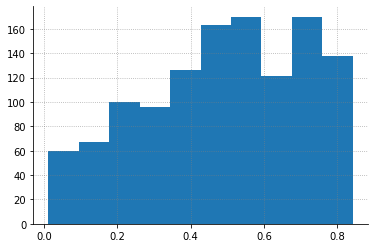

In [10]:
train_pred =pd.concat([y_pred_proba, y_train], axis =1)
train_pred.columns = ['no_churn_p', 'churn_p', 'churn_a']
train_pred = train_pred.drop(columns = ['no_churn_p'])
bins = [0, 0.1, 0.2,0.3,0.4,0.5, 0.6,0.7, 0.8,0.9,1.1]
train_pred['binned'] = pd.cut(train_pred['churn_p'], bins=bins)
train_pred[train_pred.churn_a ==1].churn_p.hist()

In [11]:
r = pd.concat([train_pred.groupby('binned').count(),train_pred.groupby('binned').sum()], axis =1)
r.columns = ['churn_p_count', 'churn_a_count', 'churn_p_sum', 'churn_a_sum']
r['churned_percentage'] = r.churn_a_sum/r.churn_a_count
r['not_churned_percentage'] = (r.churn_a_count-r.churn_a_sum)/r.churn_a_count
r.fillna(0)

,churn_p_count,churn_a_count,churn_p_sum,churn_a_sum,churned_percentage,not_churned_percentage
binned,,,,,,
"(0.0, 0.1]",1635,1635,64.770414,66,0.040367,0.959633
"(0.1, 0.2]",598,598,87.702605,81,0.135452,0.864548
"(0.2, 0.3]",517,517,127.129666,127,0.245648,0.754352
"(0.3, 0.4]",405,405,140.521620,129,0.318519,0.681481
"(0.4, 0.5]",433,433,192.990492,190,0.438799,0.561201
"(0.5, 0.6]",332,332,182.945788,194,0.584337,0.415663
"(0.6, 0.7]",250,250,163.245531,176,0.704000,0.296000
"(0.7, 0.8]",238,238,177.953444,168,0.705882,0.294118
"(0.8, 0.9]",92,92,75.106750,80,0.869565,0.130435


(0.0, 1.0)

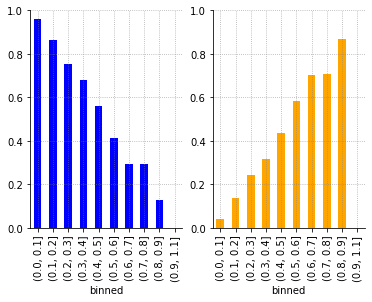

In [12]:
plt.subplot(122)
r.churned_percentage.plot(kind = 'bar', color= 'orange', alpha = 1)
plt.ylim(0,1.0)
plt.subplot(121)
r.not_churned_percentage.plot(kind = 'bar', color = 'blue', alpha = 1)
plt.ylim(0,1.0)

In [13]:
y_pred = logit.predict(X_validate_scaled)
y_pred_proba = logit.predict_proba(X_validate_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_validate, yhat.churn))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       823
           1       0.57      0.75      0.65       302

    accuracy                           0.78      1125
   macro avg       0.73      0.77      0.74      1125
weighted avg       0.81      0.78      0.79      1125



In [35]:
y_pred = logit.predict(X_test_scaled)
y_pred_proba = logit.predict_proba(X_test_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_test, yhat.churn))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1051
           1       0.51      0.79      0.62       356

    accuracy                           0.75      1407
   macro avg       0.71      0.77      0.72      1407
weighted avg       0.81      0.75      0.77      1407



In [15]:
# Generate csv file for whole dataset
#y_pred = logit.predict(X_validate_scaled)

In [16]:
weights = pd.Series(logit.coef_[0],
index=X_train_scaled.columns.values)
features = pd.DataFrame(weights.sort_values(ascending = False))
#features.to_csv('features.csv')
features

,0
internet_service_type_Fiber optic,0.811128
contract_type_Month-to-month,0.633151
tenure_years_0.0,0.587829
payment_type_Electronic check,0.317754
senior_citizen,0.243929
tenure_years_1.0,0.213776
tenure_years_3.0,0.043750
phone_service_0,-0.004240
tenure_years_2.0,-0.040493
tenure_years_4.0,-0.051827


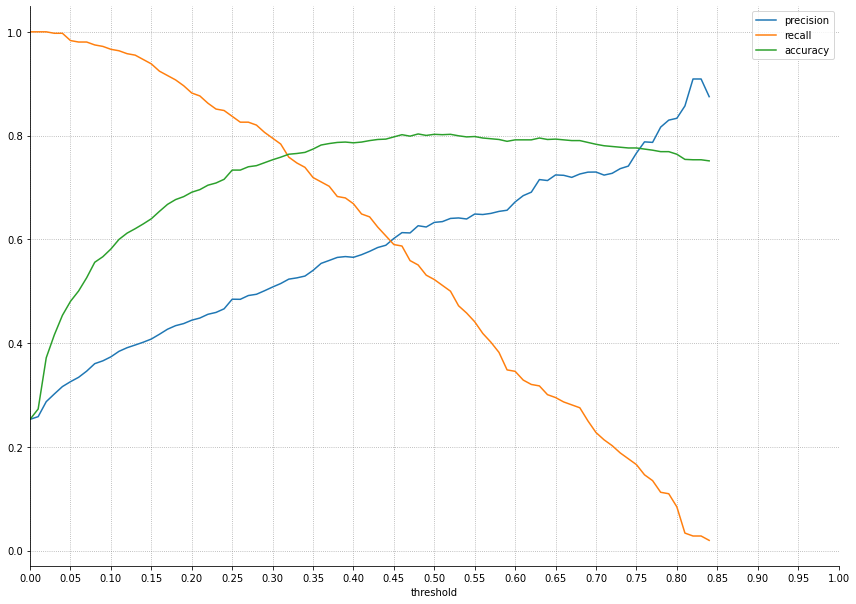

In [17]:
logistic_regression_util.plot_metrics_by_thresholds(y_test.churn, y_pred_proba.churn)

In [18]:
model_list = []
f1_list = []
auc_list = []
ll_list = []
roc_auc_list = []
time_list = []

In [19]:
# print('\n”””””” LogisticRegression “”””””')
# print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
# kf = KFold(n_splits=5, random_state=21, shuffle=True) 
# score_list = []
# c_list = 10**np.linspace(-3,3,200)
# for c in c_list:
#     logit = LogisticRegression(C = c)
#     cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
#     score_list.append(cvs)
#     print('{:.4f}'.format(cvs), end=", ") # 4 decimal pl
#     print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
#     optimal_c = float(c_list[score_list.index(max(score_list))])
#     print('optimal value of C = {:.3f}'.format(optimal_c))


# time1 = time.time()
# logit = LogisticRegression(C = optimal_c)
# model.model_report('LogisticRegression', logit, X_train_scaled, y_train, X_validate_scaled, y_validate)
    
# model_list.append('LogisticRegression')
#     print(y_validate.to_numpy())
#     print(y_pred)
#     model_f1 = f1_score(y_validate, y_pred)
#     y_pred = logit.predict_proba(X_validate)
#     model_ll = log_loss(y_validate, y_pred)
#     #print(model_name, 'Log-loss: {:.4f}'.format(model_ll))
#     y_pred = logit.predict(X_validate)
#     model_roc_auc = roc_auc_score(y_validate, y_pred)
#     #print(model_name, 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 
#     y_pred = logit.predict_proba(X_validate)[:,1]
#     fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
#     model_auc = auc(fpr, tpr)
#     #print(model_name, 'AUC: {:.4f}'.format(model_auc))
#     f1_list.append(model_f1)
#     auc_list.append(model_auc)
#     ll_list.append(model_ll)
#     roc_auc_list.append(model_roc_auc)
#     time_list.append(time.time() - time1)

# Random Forest

In [20]:
clf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=1000,
                            max_depth=5, 
                            random_state=42)

In [21]:
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_train_scaled)

In [22]:
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.823212,0.699371,0.801333,0.761291,0.789885
recall,0.927334,0.459125,0.801333,0.693229,0.801333
f1-score,0.872176,0.554337,0.801333,0.713257,0.786642
support,3289.000000,1211.000000,0.801333,4500.000000,4500.000000


In [23]:
y_pred_proba = clf.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_train, yhat.churn))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      3289
           1       0.53      0.81      0.64      1211

    accuracy                           0.75      4500
   macro avg       0.72      0.77      0.73      4500
weighted avg       0.81      0.75      0.77      4500



In [24]:
y_pred = clf.predict(X_validate_scaled)
y_pred_proba = clf.predict_proba(X_validate_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_validate, yhat.churn))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       823
           1       0.55      0.79      0.65       302

    accuracy                           0.77      1125
   macro avg       0.73      0.78      0.74      1125
weighted avg       0.81      0.77      0.78      1125



In [25]:
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_test, yhat.churn))

              precision    recall  f1-score   support

           0       0.92      0.72      0.80      1051
           1       0.49      0.81      0.61       356

    accuracy                           0.74      1407
   macro avg       0.70      0.76      0.71      1407
weighted avg       0.81      0.74      0.76      1407



# K Neighbor (KNN)

In [43]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [44]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [45]:
y_pred = knn.predict(X_train_scaled)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3289
           1       0.74      0.66      0.70      1211

    accuracy                           0.85      4500
   macro avg       0.81      0.79      0.80      4500
weighted avg       0.84      0.85      0.84      4500



In [46]:
y_pred_proba = knn.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.30
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_train, yhat.churn))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      3289
           1       0.60      0.85      0.70      1211

    accuracy                           0.81      4500
   macro avg       0.77      0.82      0.78      4500
weighted avg       0.84      0.81      0.82      4500



In [50]:
y_pred = knn.predict(X_validate_scaled)
y_pred_proba = knn.predict_proba(X_validate_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_validate, yhat.churn))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       823
           1       0.51      0.70      0.59       302

    accuracy                           0.74      1125
   macro avg       0.69      0.73      0.70      1125
weighted avg       0.77      0.74      0.75      1125



In [51]:
y_pred = knn.predict(X_test_scaled)
y_pred_proba = knn.predict_proba(X_test_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.3
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_test, yhat.churn))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1051
           1       0.46      0.69      0.55       356

    accuracy                           0.71      1407
   macro avg       0.66      0.71      0.67      1407
weighted avg       0.77      0.71      0.73      1407



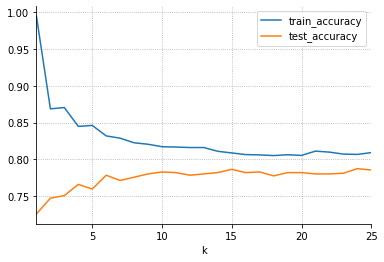

In [32]:
util.plot_k_vs_accuracy(X_train_scaled, y_train, X_validate_scaled, y_validate)

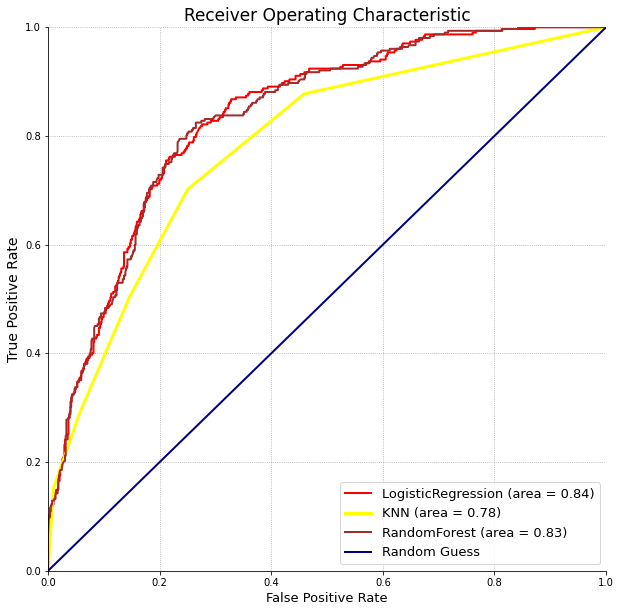

In [33]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
# plot the ROC curves
plt.figure(figsize=(10,10))



y_pred = logit.predict_proba(X_validate_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression (area = %0.2f)' % auc(fpr, tpr))
         
y_pred = knn.predict_proba(X_validate_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


y_pred = clf.predict_proba(X_validate_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()